In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/content/heart.csv")

# First look
print(df.shape)
df.head()


(918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [2]:
# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df.head()


,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df.isnull().sum()


,0
age,0
sex,0
chestpaintype,0
restingbp,0
cholesterol,0
fastingbs,0
restingecg,0
maxhr,0
exerciseangina,0
oldpeak,0


In [4]:
# Separate columns by type
num_cols = df.select_dtypes(include=['int64','float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Fill numeric missing with median
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical missing with mode
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


In [5]:
df = df.drop_duplicates()


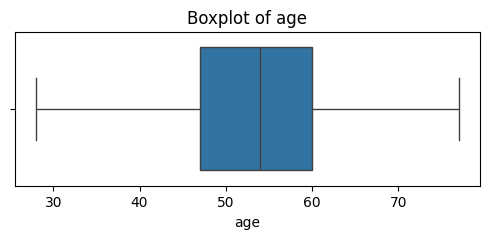

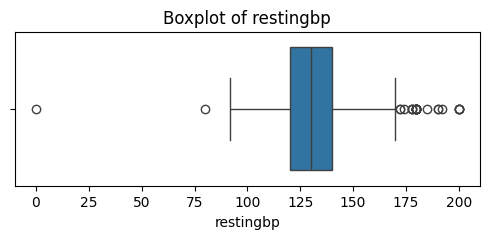

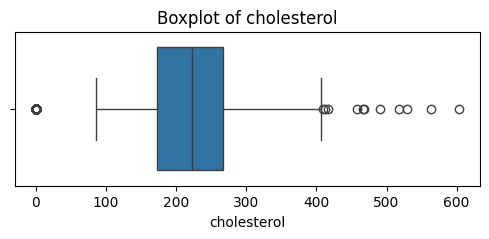

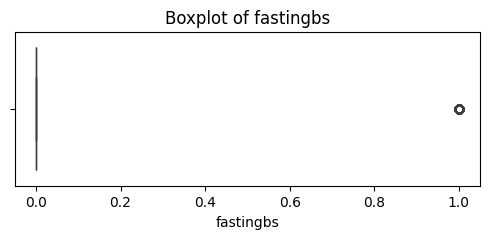

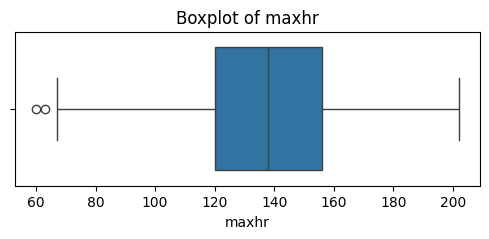

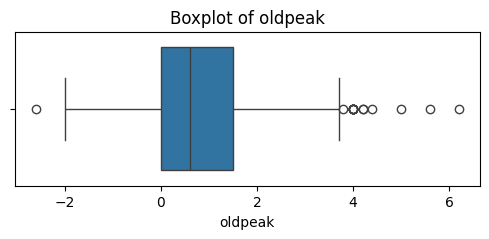

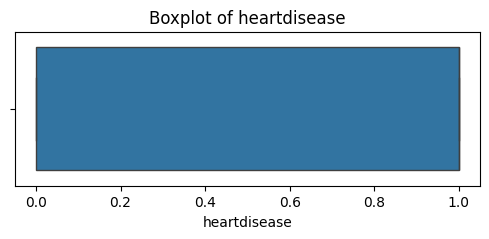

In [6]:
for col in num_cols:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [7]:
for col in num_cols:
    q1 = df[col].quantile(0.01)
    q99 = df[col].quantile(0.99)
    df[col] = df[col].clip(q1, q99)


In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [9]:
cat_cols = df.select_dtypes(include=['object']).columns
print("Categorical Columns:", cat_cols.tolist())

# Label Encoding for categorical features
encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])


Categorical Columns: ['sex', 'chestpaintype', 'restingecg', 'exerciseangina', 'st_slope']


In [10]:
# Age groups
df['age_group'] = pd.cut(df['age'],
                         bins=[0, 40, 60, 100],
                         labels=['young', 'middle', 'senior'])

# Encode new categorical column
df['age_group'] = encoder.fit_transform(df['age_group'])

# Ratio feature (blood pressure vs cholesterol)
if 'trestbps' in df.columns and 'chol' in df.columns:
    df['bp_chol_ratio'] = df['trestbps'] / (df['chol'] + 1)


In [13]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.drop('heartdisease')  # keep target separate

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [15]:
X = df.drop('heartdisease', axis=1)
y = df['heartdisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (734, 12) Test shape: (184, 12)


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [18]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


In [19]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None
    })

    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred))
    print()

results_df = pd.DataFrame(results)
results_df


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        82
           1       0.86      0.91      0.89       102

    accuracy                           0.87       184
   macro avg       0.87      0.86      0.87       184
weighted avg       0.87      0.87      0.87       184


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        82
           1       0.90      0.92      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184


=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        82
           1       0.90      0.90      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:06:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        82
           1       0.88      0.86      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184




,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Logistic Regression,0.869565,0.861111,0.911765,0.885714,0.897896
1,Random Forest,0.902174,0.903846,0.921569,0.912621,0.934959
2,Gradient Boosting,0.891304,0.901961,0.901961,0.901961,0.936035
3,XGBoost,0.858696,0.880000,0.862745,0.871287,0.927786


<Figure size 1000x600 with 0 Axes>

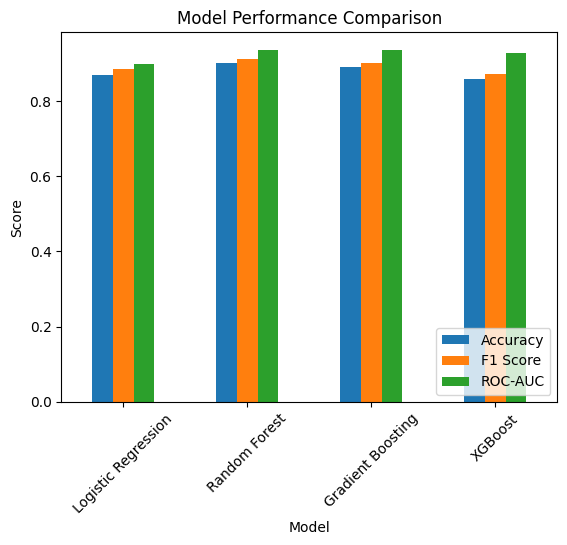

In [20]:
plt.figure(figsize=(10,6))
results_df.set_index("Model")[["Accuracy","F1 Score","ROC-AUC"]].plot(kind='bar')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()


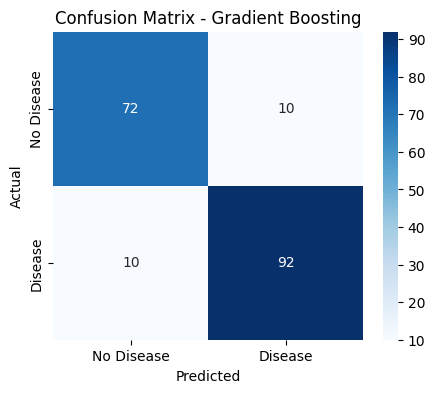

In [21]:
best_model_name = results_df.sort_values("ROC-AUC", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]

y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Disease","Disease"], yticklabels=["No Disease","Disease"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()
